### H(z) Reconstrution via Gaussian Process (GP)

 /home/lazarolima/.local/lib/python3.12/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


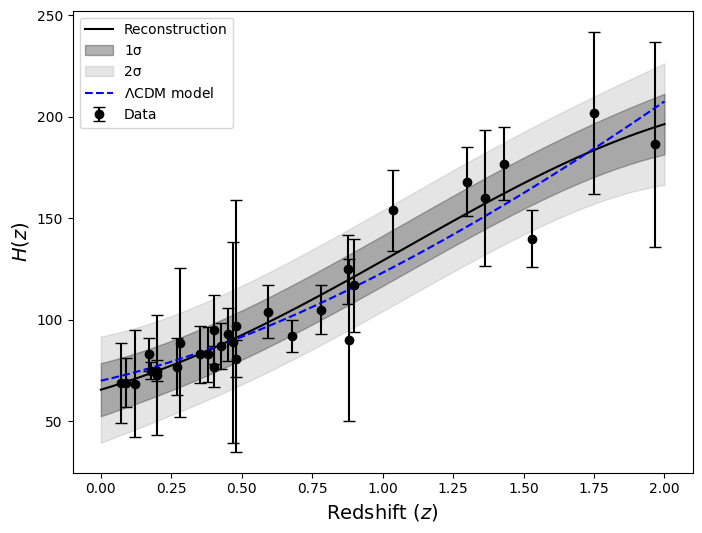

In [18]:
from gaussian_process import GPReconstructionH
from plots_rec import HReconstructionPlot
from equations import FiducialModel
import numpy as np

# Load your data
data_Hz = np.loadtxt('data/Hz31.txt')
z_values = data_Hz[:, 0]
H_obs = data_Hz[:, 1]
errors = data_Hz[:, 2]

# Choose the GP parameters
kernel_par = {'input_dim': 1, 'variance': 100., 'lengthscale': 0.1}
gp_h = GPReconstructionH(z_values, H_obs, errors, kernel_par)
gp_h.optimize(num_restarts=10, verbose=False)
mean, var, mean_deriv, var_deriv = gp_h.predict()

fiducial_model = FiducialModel()

# Plot the figure
plotter = HReconstructionPlot(gp_h, fiducial_model)
plotter.plot('Figuras/H_reconstructed.png')

### H(z) Reconstrution via Artificial Neural Network (ANN): ReFANN code

FcNet(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Linear(in_features=4096, out_features=2, bias=True)
  )
)

Training the network using CPU
(iteration:2000/30000; loss:0.35738; lr:0.03414549)
(iteration:4000/30000; loss:0.18681; lr:0.01165914)
(iteration:6000/30000; loss:0.27096; lr:0.00398107)
(iteration:8000/30000; loss:0.19248; lr:0.00135936)
(iteration:10000/30000; loss:0.20362; lr:0.00046416)
(iteration:12000/30000; loss:0.27598; lr:0.00015849)
(iteration:14000/30000; loss:0.14194; lr:0.00005412)
(iteration:16000/30000; loss:0.21472; lr:0.00001848)
(iteration:18000/30000; loss:0.16456; lr:0.00000631)
(iteration:20000/30000; loss:0.17928; lr:0.00000215)
(iteration:22000/30000; loss:0.13913; lr:0.00000074)
(iteration:24000/30000; loss:0.23187; lr:0.00000025)
(iteration:26000/30000; loss:0.18759; lr:0.00000009)

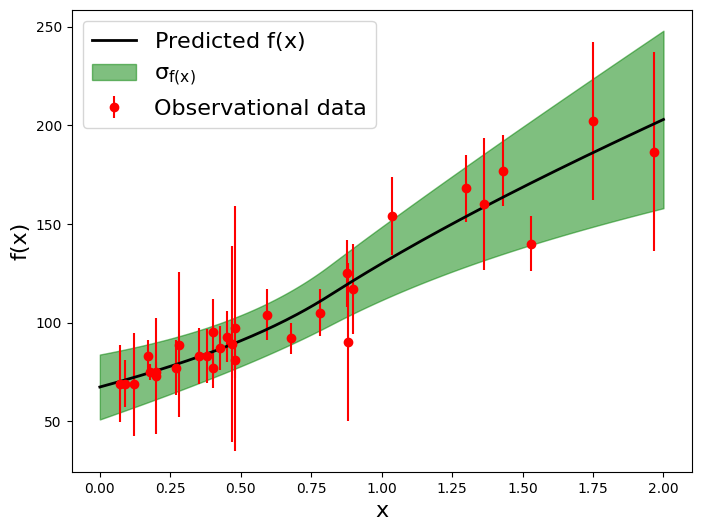

In [2]:
import refann as rf
import time
import numpy as np
import matplotlib.pyplot as plt

# Starting the ANN
start_time = time.time()

Hz = np.loadtxt('data/Hz31.txt')

rec = rf.ANN(Hz,mid_node=4096,hidden_layer=1,hp_model='rec_2')
rec.iteration = 30000
rec.train()
func = rec.predict(xpoint=np.linspace(0, 2, 201))
#func = rec.predict(xspace=(0, 2, 201)) #or use this
rec.save_func(path='data', obsName='Hz31') #save the reconstructed function

# rec.plot_loss()
rec.plot_func()
print ("Time elapsed: %.3f mins" %((time.time()-start_time)/60))
plt.show()

# Generating FRBs Mock data

#### DM_IGM reconstruction throught GP

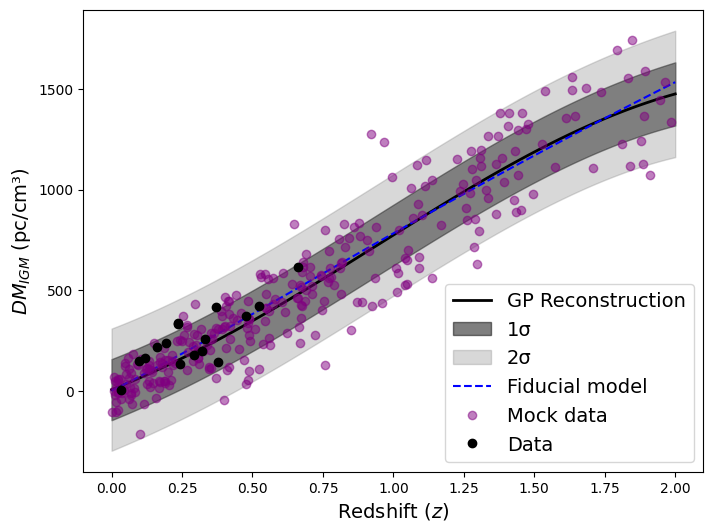

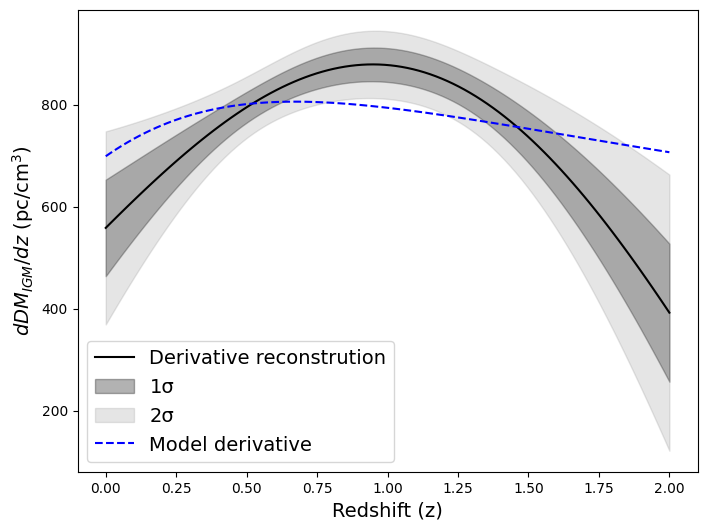

In [20]:
from gaussian_process import GPReconstructionDMIGM
from plots_rec import DMIGMReconstructionPlot
import numpy as np

# Parameters for generating new data mock via GP
n_new = 300  # Number of new data points
z_max = 2  # Máximo redshift
kernel_params = {'input_dim': 1, 'variance': 1., 'lengthscale': 0.2}
gp_dm_igm = GPReconstructionDMIGM(n_new, z_max, kernel_params)
gp_dm_igm.optimize(num_restarts=10, verbose=False)
new_z = gp_dm_igm.new_z
DM_IGM_sim = gp_dm_igm.DM_IGM_sim

# Plot the figures
plotter = DMIGMReconstructionPlot(gp_dm_igm, new_z, DM_IGM_sim)
plotter.plot_DM('Figuras/DM_IGM_reconstructed.png')
plotter.plot_dDM('Figuras/dDM_IGM_reconstructed.png')

#### DM_IGM reconstruction throught ANN

FcNet(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Linear(in_features=4096, out_features=2, bias=True)
  )
)

Training the network using CPU
(iteration:2000/30000; loss:0.32141; lr:0.03414549)
(iteration:4000/30000; loss:0.30393; lr:0.01165914)
(iteration:6000/30000; loss:0.32902; lr:0.00398107)
(iteration:8000/30000; loss:0.34596; lr:0.00135936)
(iteration:10000/30000; loss:0.33495; lr:0.00046416)
(iteration:12000/30000; loss:0.34125; lr:0.00015849)
(iteration:14000/30000; loss:0.36617; lr:0.00005412)
(iteration:16000/30000; loss:0.31998; lr:0.00001848)
(iteration:18000/30000; loss:0.32886; lr:0.00000631)
(iteration:20000/30000; loss:0.32898; lr:0.00000215)
(iteration:22000/30000; loss:0.30236; lr:0.00000074)
(iteration:24000/30000; loss:0.31106; lr:0.00000025)
(iteration:26000/30000; loss:0.36156; lr:0.00000009)

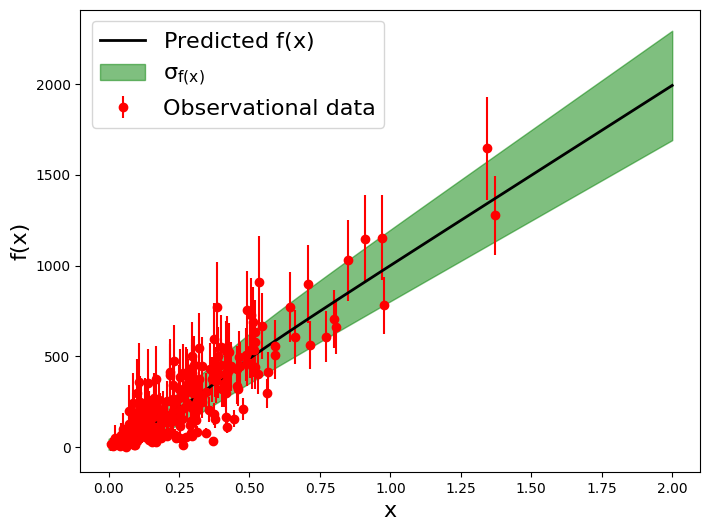

In [4]:
import refann as rf
import time

#DM_IGM = np.loadtxt('data/DM_IGM_sim.txt') # my toy model

DM_IGM = np.loadtxt('data/DM_IGM_detected_bingo+mirror_4m_alpha=-1.5_5yrs_with_erros.txt', skiprows=1)

rec = rf.ANN(DM_IGM,mid_node=4096,hidden_layer=1,hp_model='rec_2')
rec.iteration = 30000
rec.train()
func = rec.predict(xpoint=np.linspace(0, 2, 201))
#func = rec.predict(xspace=(0, 2, 201)) #or use this
rec.save_func(path='data', obsName='DM_IGM_bingo') #save the reconstructed function

# rec.plot_loss()
rec.plot_func()


print ("Time elapsed: %.3f mins" %((time.time()-start_time)/60))
plt.show()

# Bayesian analyses and MCMC

### Defining priors

In [5]:
from likelihood import Priors, LikelihoodFunction
from equations import H_Model

model = H_Model()

# Defining the prior intervals manually
intervals_constant = [(0, 1)]  # Interval for $f_{IGM}$
intervals_p2 = [(0, 1), (0, 5)]  # Intervals for $f_{IGM}$ and $\alpha$
intervals_p3 = [(0, 1), (0, 5)]  # Intervals for $f_{IGM}$ and $\alpha$
intervals_p4 = [(0, 1), (-5, 5)]  # Intervals for $f_{IGM}$ and $s$

# Creating specific instances of the priors
P_constant = Priors(['$f_{IGM}$'], intervals_constant)
P_p2 = Priors(['$f_{IGM}$', '$\\alpha$'], intervals_p2)
P_p3 = Priors(['$f_{IGM}$', '$\\alpha$'], intervals_p3)
P_p4 = Priors(['$f_{IGM}$', '$s$'], intervals_p4)

# Creating an instance of the likelihood model
LF_constant = LikelihoodFunction(lambda z, f_IGM: model.H_p(z, f_IGM, None, 'constant', 'ANN'))
LF_p2 = LikelihoodFunction(lambda z, f_IGM, alpha: model.H_p(z, f_IGM, alpha, 'p2', 'ANN'))
LF_p3 = LikelihoodFunction(lambda z, f_IGM, alpha: model.H_p(z, f_IGM, alpha, 'p3', 'ANN'))
LF_p4 = LikelihoodFunction(lambda z, f_IGM, s: model.H_p(z, f_IGM, s, 'p4', 'ANN'))
"""LF_constant = LikelihoodFunction(lambda z, f_IGM: model.H_p(z, f_IGM, None, 'constant'))
LF_p2 = LikelihoodFunction(lambda z, f_IGM, alpha: model.H_p(z, f_IGM, alpha, 'p2'))
LF_p3 = LikelihoodFunction(lambda z, f_IGM, alpha: model.H_p(z, f_IGM, alpha, 'p3'))
LF_p4 = LikelihoodFunction(lambda z, f_IGM, s: model.H_p(z, f_IGM, s, 'p4'))"""

"LF_constant = LikelihoodFunction(lambda z, f_IGM: model.H_p(z, f_IGM, None, 'constant'))\nLF_p2 = LikelihoodFunction(lambda z, f_IGM, alpha: model.H_p(z, f_IGM, alpha, 'p2'))\nLF_p3 = LikelihoodFunction(lambda z, f_IGM, alpha: model.H_p(z, f_IGM, alpha, 'p3'))\nLF_p4 = LikelihoodFunction(lambda z, f_IGM, s: model.H_p(z, f_IGM, s, 'p4'))"

### Preparing the samples

In [6]:
from obs_data import H_data
import ultranest

z_values = H_data.z_func()
H_obs = H_data.H_func()
errors = H_data.errors_func()
model = H_Model()

# Configuring the ultranest samplers
sampler_constant = ultranest.ReactiveNestedSampler(P_constant.param_names,
    lambda params: LF_constant.log_likelihood(params, z_values, H_obs, errors),
    P_constant.prior_transform
)

sampler_p2 = ultranest.ReactiveNestedSampler(P_p2.param_names,
    lambda params: LF_p2.log_likelihood(params, z_values, H_obs, errors),
    P_p2.prior_transform
)

sampler_p3 = ultranest.ReactiveNestedSampler(P_p3.param_names,
    lambda params: LF_p3.log_likelihood(params, z_values, H_obs, errors),
    P_p3.prior_transform
)

sampler_p4 = ultranest.ReactiveNestedSampler(P_p4.param_names,
    lambda params: LF_p4.log_likelihood(params, z_values, H_obs, errors),
    P_p4.prior_transform
)


In [7]:
result1 = sampler_constant.run(min_num_live_points=400)
sampler_constant.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.8874..-10.8874]*| it/evals=3520/3995 eff=97.9138% N=400  
[ultranest] Likelihood function evaluations: 4027
[ultranest]   logZ = -15.15 +- 0.06548
[ultranest] Effective samples strategy satisfied (ESS = 1473.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)
[ultranest]   logZ error budget: single: 0.09 bs:0.07 tail:0.01 total:0.07 required:<0.50
[ultranest] done iterating.

logZ = -15.160 +- 0.139
  single instance: logZ = -15.160 +- 0.093
  bootstrapped   : logZ = -15.146 +- 0.139
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    $f_{IGM}$           : 0.9249│ ▁   ▁  ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▆▇▇│1.0000    0.9889 +- 0.0095



In [8]:
result2 = sampler_p2.run(min_num_live_points=400)
sampler_p2.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  20 [-8.2130..-8.2130]*| it/evals=4050/5604 eff=77.8248% N=400 00    
[ultranest] Likelihood function evaluations: 5638
[ultranest]   logZ = -13.78 +- 0.08379
[ultranest] Effective samples strategy satisfied (ESS = 1509.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -13.799 +- 0.175
  single instance: logZ = -13.799 +- 0.109
  bootstrapped   : logZ = -13.784 +- 0.174
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    $f_{IGM}$           : 0.759 │ ▁ ▁▁▁ ▁▁▁▁▁▁▂▁▂▂▂▂▃▃▃▆▆▄▆▆▆▇▆▇▇▆▆▆▅▆▅▄│1.000     0.934 +- 0.041
    $\alpha$            : 0.00  │▁▁▁▂▂▂▄▄▆▅▇▇▇▇▆▇▇▇▆▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁ ▁ │0.82      0.31 +- 0.12



In [9]:
result3 = sampler_p3.run(min_num_live_points=400)
sampler_p3.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  87 [-7.8807..-7.8807]*| it/evals=3760/5408 eff=75.0799% N=400 0  0 
[ultranest] Likelihood function evaluations: 5434
[ultranest]   logZ = -12.71 +- 0.07479
[ultranest] Effective samples strategy satisfied (ESS = 1486.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -12.707 +- 0.154
  single instance: logZ = -12.707 +- 0.100
  bootstrapped   : logZ = -12.711 +- 0.154
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    $f_{IGM}$           : 0.626 │ ▁ ▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▄▃▅▆▆▆▆▆▇▇▇▇▇▇▆▆▅▅▄▄▃│1.000     0.887 +- 0.062
    $\alpha$            : 0.00  │▁▁▁▁▃▂▄▄▅▅▇▇▇▆▇▇▆▆▅▅▅▄▃▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁ │1.54      0.58 +- 0.24



In [10]:
result4 = sampler_p4.run(min_num_live_points=400)
sampler_p4.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-10.3433..-10.3433]*| it/evals=5360/8661 eff=64.8832% N=400 0  0 0 0 
[ultranest] Likelihood function evaluations: 8690
[ultranest]   logZ = -19.21 +- 0.1104
[ultranest] Effective samples strategy satisfied (ESS = 1884.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = -19.178 +- 0.117
  single instance: logZ = -19.178 +- 0.136
  bootstrapped   : logZ = -19.214 +- 0.116
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    $f_{IGM}$           : 0.600 │ ▁    ▁  ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▄▅▅▆▇│1.000     0.947 +- 0.047
    $s$                 : -0.297│ ▁         ▁▁ ▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅▆▇▅▃▁▁▁ │0.037     -0.034 +- 0.026



In [11]:
from getdist import plots, MCSamples

# Extraindo amostras dos resultados
samples1 = result1['samples']
samples2 = result2['samples']
samples3 = result3['samples']
samples4 = result4['samples']

# Criando objetos MCSamples com os dados
labels1 = ['f_{IGM,0}']
names1 = ['f_IGM']
mcsamples1 = MCSamples(samples=samples1, names=names1, labels=labels1)

labels2 = ['f_{IGM,0}', '\\alpha']
names2 = ['f_IGM', 'alpha']
mcsamples2 = MCSamples(samples=samples2, names=names2, labels=labels2)
mcsamples3 = MCSamples(samples=samples3, names=names2, labels=labels2)

labels3 = ['f_{IGM,0}', 's']
names3 = ['f_IGM', 's']
mcsamples4 = MCSamples(samples=samples4, names=names3, labels=labels3)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


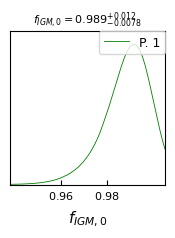

In [12]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples1.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples1, filled=True, contour_colors=['green'], 
                legend_labels=['P. 1'], 
                title_limit=1)
g.export('Figuras/H_p1.png', dpi=600)

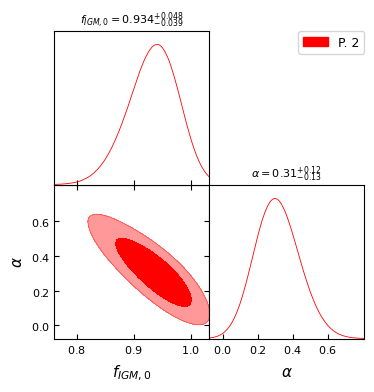

In [13]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples2.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples2, filled=True, contour_colors=['red'],
                legend_labels=['P. 2'], title_limit=1)
g.export('Figuras/H_p2.png', dpi=600)

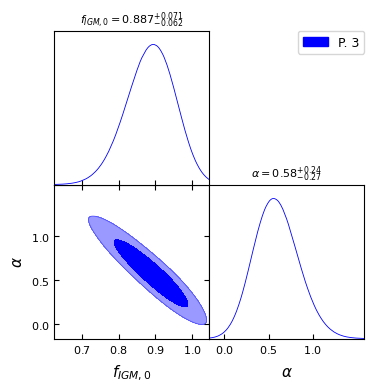

In [14]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples3.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples3, filled=True, contour_colors=['blue'],
                legend_labels=['P. 3'], title_limit=1)
g.export('Figuras/H_p3.png', dpi=600)

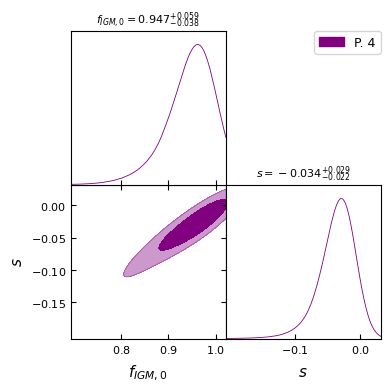

In [17]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples4.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples4, filled=True, contour_colors=['purple'],
                legend_labels=['P. 4'], title_limit=1)
g.export('Figuras/H_p4.png', dpi=600)

In [ ]:
from ultranest.plot import PredictionBand
from equations import H_Model

plt.figure()
plt.xlabel('$z$')
plt.ylabel('H(z)')
plt.errorbar(x=z_values, y=H_obs, yerr=errors, marker='o', capsize=3, ls=' ', color='purple', label='$DM_{ext}^{obs}$')

band = PredictionBand(z_test.flatten())

# go through the solutions
for f_IGM  in sampler_constant.results['samples']:
    # compute for each time the y value
    model = H_Model()
    band.add(model.H_p(z_test.flatten(), f_IGM=f_IGM))

band.line(color='k', linestyle='--', label='$H_{P1}$', linewidth=1.5)
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)

plt.legend()
plt.savefig('Figuras/H_bestfit.png', format='png', dpi=600)